# https://gautham2k2-next-words-prediction-app-4ffoqr.streamlit.app/

# Please click on the above link to open streamlit app in your browser

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [ ]:
!wget https://www.gutenberg.org/files/1661/1661-0.txt -O sherlock.txt

--2024-10-28 15:36:58--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607504 (593K) [text/plain]
Saving to: ‘sherlock.txt’

sherlock.txt        100%[===================>] 593.27K  3.37MB/s    in 0.2s    

2024-10-28 15:36:59 (3.37 MB/s) - ‘sherlock.txt’ saved [607504/607504]



In [ ]:
data = open('sherlock.txt', 'r', encoding='utf-8').read()

In [ ]:
import re
data = data.replace('\n', '  ')
data = re.sub(r'([a-zA-Z0-9])([\.])', r'\1 \2', data)
data = re.sub('[^a-zA-Z0-9 \.]', '', data).lower()

In [ ]:
words = data.split()

In [ ]:
len(words)

113920

In [ ]:
words = words[254:]

In [ ]:
# Now we have to a vocabulary and do mapping to each words

words_set = list(set(words))
if '.' in words_set:
    words_set.remove('.')
stoi = {s:i+1 for i,s in enumerate(words_set)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

Streaming output truncated to the last 5000 lines.
 3690: 'doublebedded',
 3691: 'ruse',
 3692: 'beckoning',
 3693: 'undid',
 3694: 'accountant',
 3695: 'foliage',
 3696: 'moodily',
 3697: 'windows',
 3698: 'smokerings',
 3699: 'drawn',
 3700: 'cooperation',
 3701: 'brain',
 3702: 'shimmering',
 3703: 'arrival',
 3704: 'refreshingly',
 3705: 'blundering',
 3706: 'recourse',
 3707: 'cotton',
 3708: 'slylooking',
 3709: 'present',
 3710: 'officers',
 3711: 'covered',
 3712: 'complicates',
 3713: 'flushed',
 3714: 'pretty',
 3715: 'approached',
 3716: 'upstairs',
 3717: 'continuously',
 3718: 'crusted',
 3719: 'inviolate',
 3720: 'everyone',
 3721: 'smoothskinned',
 3722: 'grace',
 3723: 'fullersearth',
 3724: 'bought',
 3725: 'doubts',
 3726: 'rearing',
 3727: 'affected',
 3728: 'demurely',
 3729: 'distributor',
 3730: 'thudding',
 3731: 'drowsiness',
 3732: 'handkerchiefs',
 3733: 'pleading',
 3734: 'lawyer',
 3735: 'hurriedly',
 3736: 'rapt',
 3737: 'joined',
 3738: 'case',
 3739: 'for

In [ ]:
block_size = 16
X, Y = [], []


context = [0] * block_size


for word in words:

    ix = stoi[word]


    X.append(context[:])
    Y.append(ix)

    print(' '.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]


Streaming output truncated to the last 5000 lines.
cut off very possibly in some illness through which she has passed and so of course ---> yours
off very possibly in some illness through which she has passed and so of course yours ---> had
very possibly in some illness through which she has passed and so of course yours had ---> to
possibly in some illness through which she has passed and so of course yours had to ---> be
in some illness through which she has passed and so of course yours had to be ---> sacrificed
some illness through which she has passed and so of course yours had to be sacrificed ---> also
illness through which she has passed and so of course yours had to be sacrificed also ---> .
through which she has passed and so of course yours had to be sacrificed also . ---> by
which she has passed and so of course yours had to be sacrificed also . by ---> a
she has passed and so of course yours had to be sacrificed also . by a ---> curious
has passed and so of course yours ha

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

X.shape, Y.shape

(torch.Size([113666, 16]), torch.Size([113666]))

In [ ]:
# Embedding layer for the context

emb_dim = 128
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [ ]:
emb.weight

Parameter containing:
tensor([[ 0.9331,  0.3590, -0.9093,  ...,  0.6810,  0.2197,  1.8225],
        [ 0.7665, -1.6701, -0.2086,  ...,  0.2452, -0.2040,  0.1863],
        [-1.6755,  1.2263, -2.5624,  ..., -1.9603, -0.6342,  0.2531],
        ...,
        [ 0.5387,  1.3809, -0.8853,  ...,  0.2678, -0.4436, -0.1923],
        [ 1.9311, -1.5112, -1.0816,  ..., -0.8768, -0.1646,  0.8338],
        [ 0.2584,  1.4348,  0.5320,  ...,  0.6344, -0.4632, -0.2662]],
       requires_grad=True)

In [ ]:
emb.weight.shape

torch.Size([8690, 128])

In [ ]:
class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = torch.tanh(self.lin1(x))
        x = self.lin2(x)
        return x

# Defining the model
vocab_size = len(stoi)
emb_dim = 128
hidden_size = 1024

model = NextWord(block_size, vocab_size, emb_dim, hidden_size).to(device)
model = torch.compile(model)

for param_name, param in model.named_parameters():
    print(param_name, param.shape)


_orig_mod.emb.weight torch.Size([8690, 128])
_orig_mod.lin1.weight torch.Size([1024, 2048])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([8690, 1024])
_orig_mod.lin2.bias torch.Size([8690])


In [ ]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.1 MB/s eta 0:00:00


In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [ ]:
# Train the model
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
batch_size = 1000
print_every = 2
elapsed_time = []

for epoch in range(300):
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]


        x = torch.clamp(x, 0, vocab_size - 1)
        y = torch.clamp(y, 0, vocab_size - 1)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 8.256048202514648
2 2.3973114490509033
4 0.7381657958030701
6 0.26080644130706787
8 0.07506032288074493
10 0.029268164187669754
12 0.01717139221727848
14 0.011890891939401627
16 0.00888377707451582
18 0.006936619058251381
20 0.005579155869781971
22 0.004581742454320192
24 0.003820720361545682
26 0.0032238266430795193
28 0.0027455769013613462
30 0.0023557899985462427
32 0.0020337046589702368
34 0.001764447893947363
36 0.0015371897025033832
38 0.0013438282767310739
40 0.001178169739432633
42 0.0010354475816711783
44 0.0009118589805439115
46 0.0008044232963584363
48 0.0007106817793101072
50 0.0006286460557021201
52 0.0005566764739342034
54 0.0004933815216645598
56 0.00043762355926446617
58 0.00038842999492771924
60 0.0003449490759521723
62 0.00030649270047433674
64 0.00027243103249929845
66 0.0002422483521513641
68 0.0002154840185539797
70 0.00019172282190993428
72 0.00017063879931811243
74 0.00015189162513706833
76 0.00013524484529625624
78 0.00012043732567690313
80 0.00010727497283369

In [ ]:
X = torch.tensor(X)
Y = torch.tensor(Y)

<ipython-input-19-575e1b566980>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
<ipython-input-19-575e1b566980>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y)


In [ ]:
X.shape, Y.shape

(torch.Size([113666, 16]), torch.Size([113666]))

In [ ]:
def generate_text(model, initial_text, stoi, itos, block_size, k=30):
    context = initial_text.split()[-block_size:]
    context_ids = [stoi.get(word, 0) for word in context]
    context_ids = [0] * (block_size - len(context_ids)) + context_ids
    generated_text = initial_text

    for _ in range(k):
        x = torch.tensor(context_ids).view(1, -1).to(device)

        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()

        next_word = itos[ix]

        #if next_word == '.':  # Stop generation if the model predicts the end token
            #break

        generated_text += ' ' + next_word

        context_ids = context_ids[1:] + [ix]

    return generated_text

In [ ]:
#initial_text = input("")
#k = int(input("Input number of words to generate:"))  # Number of words to generate

generated_text = generate_text(model,"A man entered who could hardly have been less than six feet six inches in height", stoi, itos, block_size)
print("Generated text 1.:", generated_text)
#generated_text = generate_text(model,"It not long my friend’s prediction fulfilled A fortnight went , which I frequently found my turning.", stoi, itos, block_size)
#print("Generated text 2.:", generated_text)
#generated_text = generate_text(model,"gautham is an indian", stoi, itos, block_size)
#print("Generated text 3.:", generated_text)


Generated text 1.: A man entered who could hardly have been less than six feet six inches in height with the chest and limbs of a hercules . his dress was rich with a richness which would in england be looked upon as akin to bad taste . heavy


In [ ]:
torch.save(model.state_dict(), 'model_sherlock_9.pth')  # Save model1

In [ ]:
from google.colab import files
files.download('model_sherlock_9.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Save stoi
with open('stoi_9.pkl', 'wb') as f:
    pickle.dump(stoi, f)

# Save itos
with open('itos_9.pkl', 'wb') as f:
    pickle.dump(itos, f)


In [ ]:
embeddings = model.emb.weight.detach().cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)


/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [ ]:
embeddings_2d.shape

(8690, 2)

In [ ]:
import random
subset_words = random.sample(list(stoi.keys()), 25)

In [ ]:
subset_indices = [stoi[word] for word in subset_words]

In [ ]:
subset_embeddings = model.emb.weight[subset_indices].detach().cpu().numpy()

In [ ]:
if subset_embeddings.shape[1] > 2:
    tsne = TSNE(n_components=2, random_state=0,perplexity=min(25 - 1, 30))
    reduced_embeddings = tsne.fit_transform(subset_embeddings)
else:
    reduced_embeddings = subset_embeddings

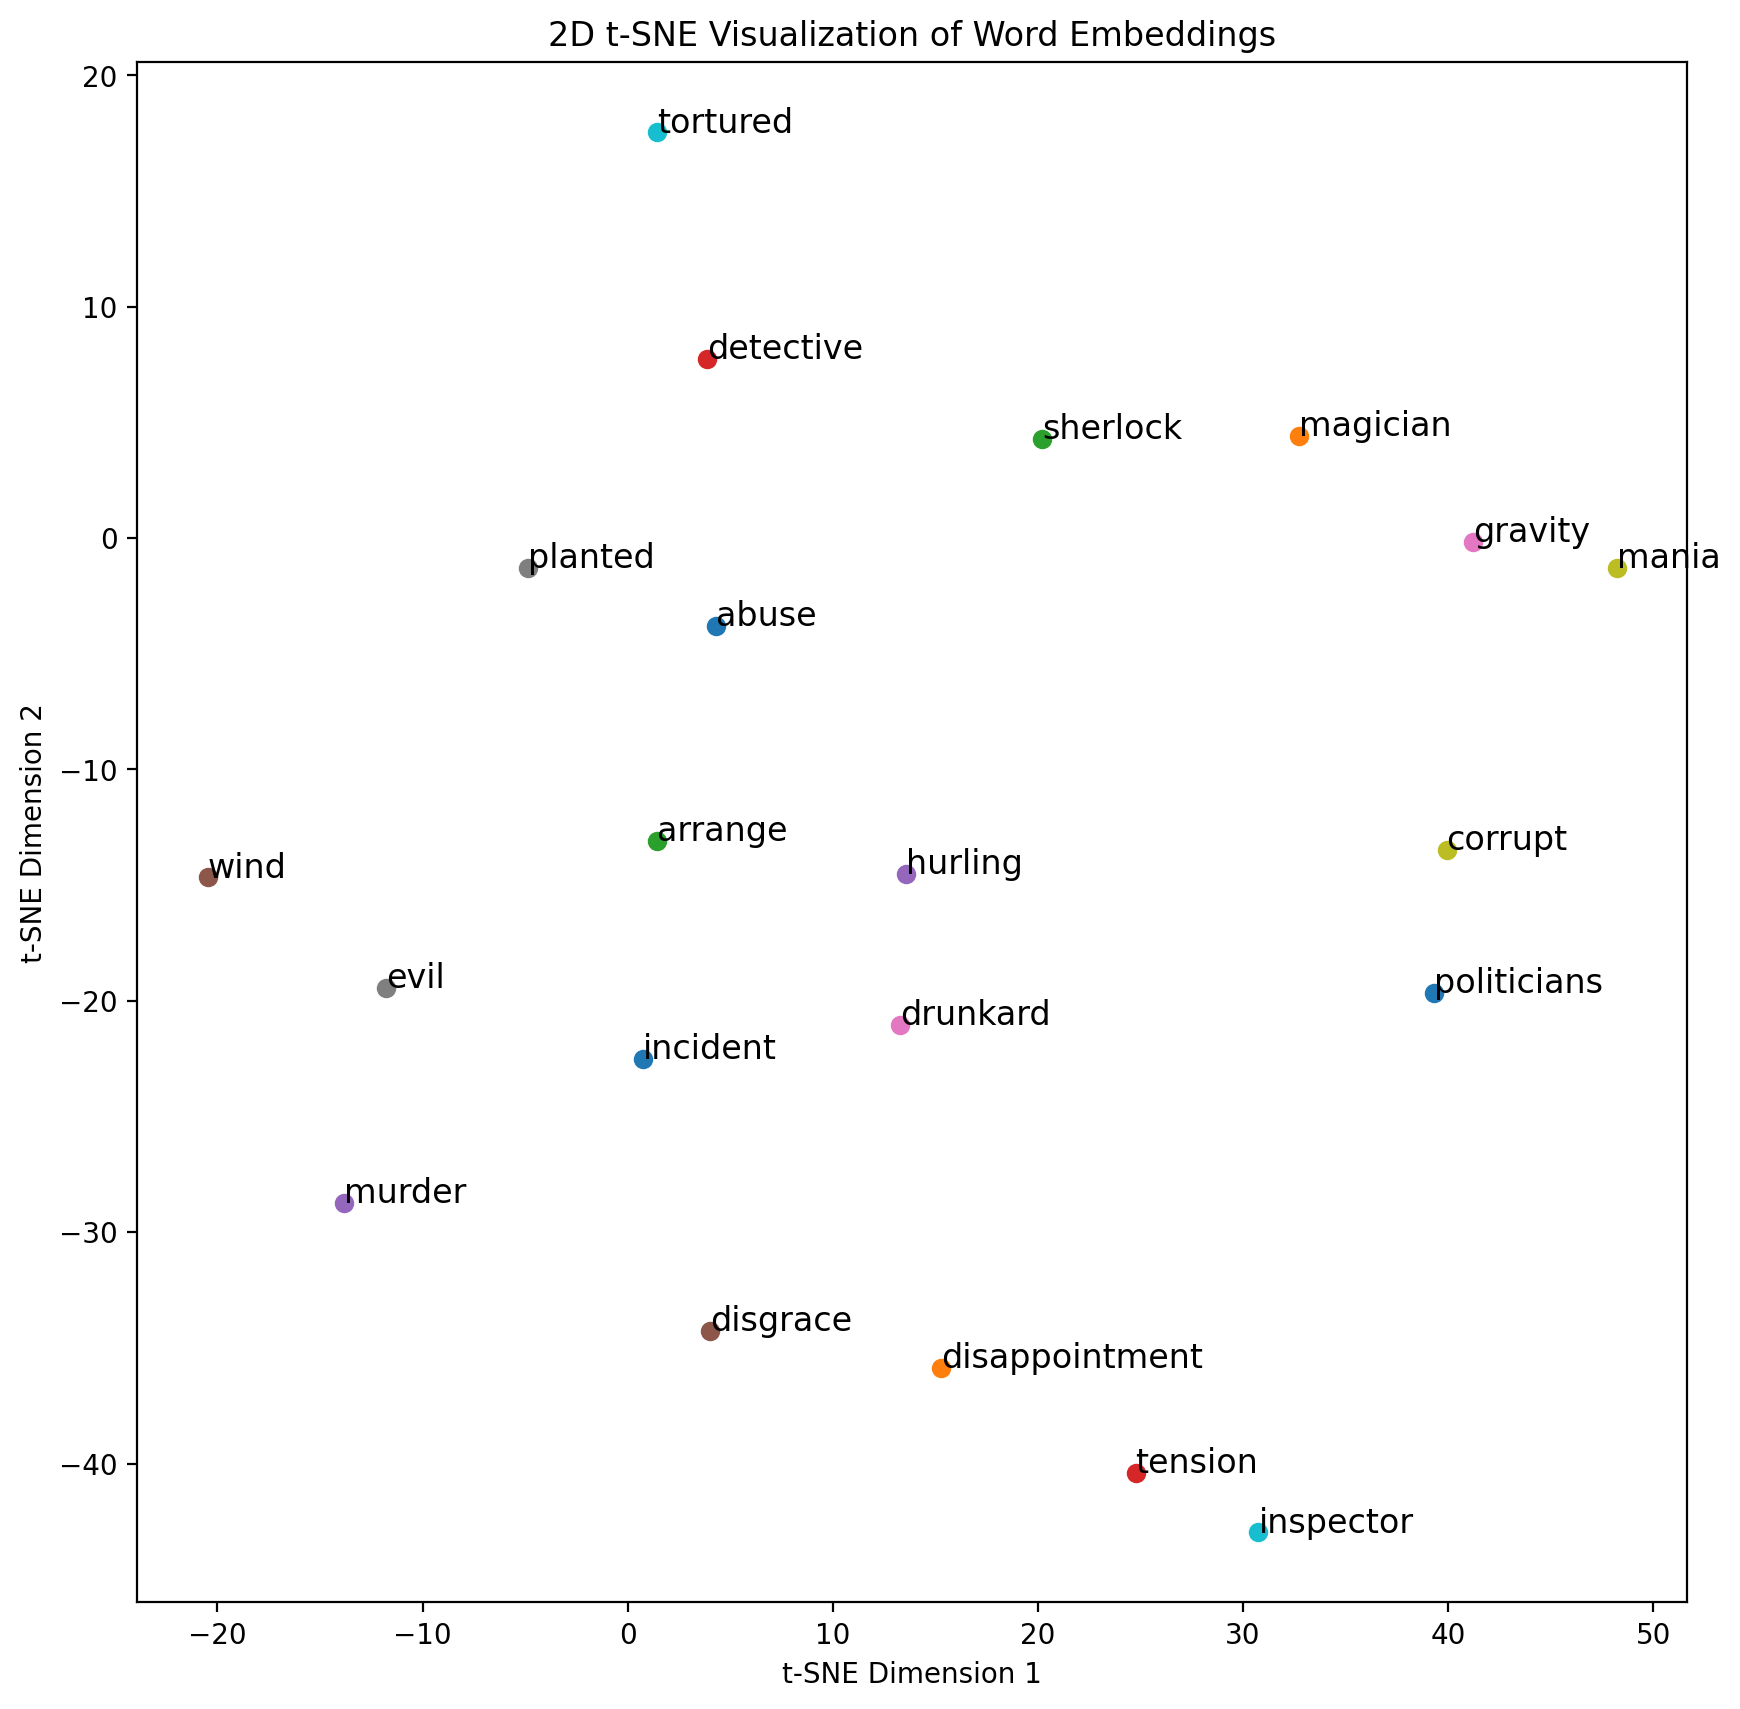

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


selected_words = ['politicians','magician','sherlock','detective','murder','wind','gravity','planted','mania','tortured','abuse','disappointment','arrange','tension','hurling','disgrace','drunkard','evil','corrupt','inspector','incident']


selected_indices = [stoi[word] for word in selected_words if word in stoi]


embeddings = model.emb.weight.detach().cpu().numpy()[selected_indices]

tsne = TSNE(n_components=2, random_state=42,perplexity=min(len(embeddings)-1,5))
embeddings_2d = tsne.fit_transform(embeddings)


plt.figure(figsize=(10, 10))
for i, word in enumerate(selected_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=12)

plt.title("2D t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


#As we can see from the above tsne graph, some words like **disgrace, disappointment, tension** and **corrupt,politicians** and **sherlock, detective** are placed closer to each other. Although some other words doesn't make much sense, still for few words, we are able to check the right relationships.